In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os

In [ ]:
import tensorflow_datasets as tfds

# Load the dataset with splits
(train_ds, val_ds), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.WYKQZH_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image, label

train_ds = train_ds.map(format_example).batch(BATCH_SIZE).prefetch(1)
val_ds = val_ds.map(format_example).batch(BATCH_SIZE).prefetch(1)


In [ ]:
base_model = VGG16(input_shape=(224, 224, 3),
                   include_top=False,
                   weights='imagenet')
base_model.trainable = False  # Freeze the convolutional base


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 159s 244ms/step - accuracy: 0.8229 - loss: 0.5995 - val_accuracy: 0.9099 - val_loss: 0.2108
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 125s 214ms/step - accuracy: 0.9098 - loss: 0.2120 - val_accuracy: 0.8940 - val_loss: 0.2535
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 125s 214ms/step - accuracy: 0.9167 - loss: 0.1988 - val_accuracy: 0.9192 - val_loss: 0.1839
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 214ms/step - accuracy: 0.9189 - loss: 0.1806 - val_accuracy: 0.9312 - val_loss: 0.1579
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 213ms/step - accuracy: 0.9357 - loss: 0.1535 - val_accuracy: 0.9297 - val_loss: 0.1718


In [ ]:
# Unfreeze some layers of the base model
base_model.trainable = True

# Freeze all layers except the last 4 layers of VGG16
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=optimizers.Adam(1e-5),  # Lower LR
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(train_ds,
                              validation_data=val_ds,
                              epochs=5)


Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 148s 243ms/step - accuracy: 0.9459 - loss: 0.1375 - val_accuracy: 0.9568 - val_loss: 0.1162
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 137s 235ms/step - accuracy: 0.9697 - loss: 0.0752 - val_accuracy: 0.9585 - val_loss: 0.1158
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 137s 236ms/step - accuracy: 0.9822 - loss: 0.0486 - val_accuracy: 0.9607 - val_loss: 0.1154
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 137s 235ms/step - accuracy: 0.9892 - loss: 0.0288 - val_accuracy: 0.9613 - val_loss: 0.1411
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 142s 235ms/step - accuracy: 0.9922 - loss: 0.0205 - val_accuracy: 0.9600 - val_loss: 0.1723


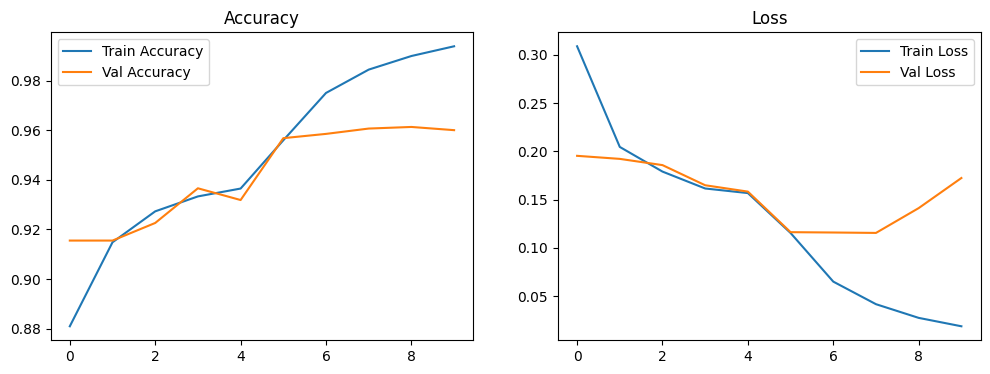

In [ ]:
def plot_history(history, fine_tune_history):
    acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
    loss = history.history['loss'] + fine_tune_history.history['loss']
    val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history, fine_tune_history)
